In [334]:
import numpy as np
import sympy as sym
import scipy as sp
import matplotlib.pyplot as plt


In [335]:
t = sym.symbols('t')

def R(theta, phi, psi):
    # ZXZ
    M=[
        [sym.cos(theta)*sym.cos(psi)-sym.cos(phi)*sym.sin(theta)*sym.sin(psi), -sym.cos(theta)*sym.sin(psi)-sym.cos(phi)*sym.cos(psi)*sym.sin(theta), sym.sin(theta)*sym.sin(phi)],
        [sym.cos(psi)*sym.sin(theta)+sym.cos(theta)*sym.cos(phi)*sym.sin(psi), sym.cos(theta)*sym.cos(phi)*sym.cos(psi)-sym.sin(theta)*sym.sin(psi), -sym.cos(theta)*sym.sin(phi)],
        [sym.sin(phi)*sym.sin(psi), sym.cos(psi)*sym.sin(phi), sym.cos(phi)],
    ]
    return sym.Matrix(M)

def Rx(x):
    return sym.Matrix([
        [1,0,0],
        [0,sym.cos(x),-sym.sin(x)],
        [0,sym.sin(x),sym.cos(x)],
    ])

def V(k, R1,R2):
    # return k*sym.trace((R1.T*R2)* R1.T * R2 *(R1.T*R2))
    return k*sym.trace((R1.T*R2)*(R1.T*R2))

def K(k, R1):
    return k*sym.trace((R1.T * R1.diff(t))*(R1.T * R1.diff(t)))

def Anis(k, R1, eq, dphi):
    # Re = Rx(dphi)*R(eq[0],eq[1],eq[2])*Rx(-dphi)
    Re = R(0,dphi,0)*R(eq[0],eq[1],eq[2])*R(0,-dphi,0)
    return k*sym.trace((R1.T * Re)*(R1.T * Re))

In [336]:
def coefficients(expresions, variables):
    """returns a [N,N] python list"""
    eqs = []
    vars = []
    for i in expresions:
        for j in i:
            eqs.append(j)

    for i in variables:
        for j in i:
            vars.append(j)

    N = len(vars)
    out = []
    for i in range(N):
        l = []
        for j in range(N):
            l.append((eqs[i].lhs).coeff(vars[j]))
        out.append(l)
    return sym.Matrix(out)


In [337]:
class System:
    def __init__(self, Nbase, indexConnections, dirconnections, a=1,k_v=1, k_k=1, k_a=1, dphi=0, Js=1):
        self.Nbase = Nbase
        self.indexConnections=indexConnections
        self.directionConnections = dirconnections
        self.a=a
        self.k = [sym.symbols("k_x"), sym.symbols("k_y")]
        self.k_v = k_v
        self.k_k = k_k
        self.k_a = k_a
        self.dphi=dphi

        t = sym.symbols('t')
        self.auxvar=[
                sym.Function(r"theta_a")(t),
                sym.Function(r"phi_a")(t),
                sym.Function(r"psi_a")(t),
        ]
        self.auxvar2 = [
            sym.Function(r"\theta_b")(t),
            sym.Function(r"\phi_b")(t),
            sym.Function(r"\psi_b")(t),
        ]
        self.auxeq = [
            sym.symbols(r"\alpha"),
            sym.symbols(r"\beta"),
            sym.symbols(r"\gamma"),
        ]
        self.auxeq2 = [
            sym.symbols(r"\alpha_2"),
            sym.symbols(r"\beta_2"),
            sym.symbols(r"\gamma_2"),
        ]

        self.eigenvecs=None
        self.eigenvals=None

        # if Js==1: self.Js = 0 * self.indexConnections + self.k_v # todos tienen el mismo J 
        # else:
        #     self.Js = Js  # debe ser un arreglo con el J de cada conexion


    def setEquilibrium(self, eq):
        t = sym.symbols('t')

        self.equilibrium = eq
        self.variables = []
        for i in range(self.Nbase):
            aux = [
                sym.Function(r"\theta_{}".format(i))(t),
                sym.Function(r"\phi_{}".format(i))(t),
                sym.Function(r"\psi_{}".format(i))(t),
            ]
            self.variables.append(aux)

        self.Rs = []
        for i in range(self.Nbase):
            R1 = R(
                self.equilibrium[i][0]+self.variables[i][0],
                self.equilibrium[i][1]+self.variables[i][1],
                self.equilibrium[i][2]+self.variables[i][2],
            )
            self.Rs.append(R1)

    def makeLagrangian(self):
        t = sym.symbols('t')

        Ls=[]

        for i in range(self.Nbase):
            kinetic = self.Kinetic(self.variables[i], self.equilibrium[i])
            potential = 0
            potential += self.Anisotropy(self.variables[i], self.equilibrium[i], i)
            for j in range(len(self.indexConnections[i])):
                idxconn = self.indexConnections[i][j]
                dirconn = self.directionConnections[i][j]
                k = 0
                for m in range(2):
                    k += dirconn[m]*self.k[m]
                factor = sym.exp(sym.I * self.a * k)
                if i==idxconn[1]:
                    var = []
                    for z in self.auxvar:
                        var.append(z*factor)
                    potential += self.Potential(self.variables[i],self.equilibrium[i], var, self.equilibrium[idxconn[i]])
                else:
                    var=[]
                    for z in self.variables[idxconn[1]]:
                        var.append(z*factor)
                    potential += self.Potential(self.variables[i], self.equilibrium[i], var,self.equilibrium[idxconn[1]])
            L = kinetic+potential
            Ls.append(L)
            #falta la anisotropía
        self.lagrangians=Ls

    def equations(self):
        t = sym.symbols('t')

        self.E_L_equations=[]
        for i in range(self.Nbase):
            eq = sym.euler_equations(self.lagrangians[i], self.variables[i],t)
            self.E_L_equations.append(eq)

        # Replace varsaux por la variable correspondiente por el factor
        # esto solo es necesario si tenemos conexion a-a o b-b, etc
        
    def Kmatrix(self):
        dvar = []
        for i in self.variables:
            l = []
            for j in i:
                l.append(j.diff(t,2))
            dvar.append(l)

        self.K = coefficients(self.E_L_equations, self.variables)
        self.W = -1*coefficients(self.E_L_equations, dvar) # el -1 es por dt^2 -> -w^2
        # self.W = coefficients(self.E_L_equations, dvar) 


    def seriesExpansion(self):
        epsilon = sym.symbols(r"\epsilon")
        littleauxvar1 = [
            self.auxeq[0] + epsilon*self.auxvar[0],
            self.auxeq[1] + epsilon*self.auxvar[1],
            self.auxeq[2] + epsilon*self.auxvar[2],
        ]
        littleauxvar2 = [
            self.auxeq2[0] + epsilon*self.auxvar2[0],
            self.auxeq2[1] + epsilon*self.auxvar2[1],
            self.auxeq2[2] + epsilon*self.auxvar2[2],
        ]
        R1 = R(littleauxvar1[0], littleauxvar1[1], littleauxvar1[2])
        R2 = R(littleauxvar2[0], littleauxvar2[1], littleauxvar2[2])

        # self.V = sym.series(V(self.k_v, R1, R2),epsilon, 0, 3).removeO().subs(epsilon,1)
        # self.K = sym.series(K(self.k_k, R1),epsilon, 0, 3).removeO().subs(epsilon,1)
        self.V = V(self.k_v, R1, R2).diff(epsilon, 2).subs(epsilon,0)
        self.K = K(self.k_k, R1).diff(epsilon, 2).subs(epsilon,0)
        self.A = Anis(self.k_a, R1, self.auxeq, self.auxeq2[0]).diff(epsilon, 2).subs(epsilon,0)
        
    def Potential(self, angles1,eq1, angles2, eq2):
        return self.V.subs([
            (self.auxvar[0], angles1[0]),(self.auxvar[1], angles1[1]),(self.auxvar[2], angles1[2]),
            (self.auxeq[0], eq1[0]),(self.auxeq[1], eq1[1]),(self.auxeq[2], eq1[2]),
            (self.auxvar2[0], angles2[0]),(self.auxvar2[1], angles2[1]),(self.auxvar2[2], angles2[2]),
            (self.auxeq2[0], eq2[0]),(self.auxeq2[1], eq2[1]),(self.auxeq2[2], eq2[2]),
            ])

    def Kinetic(self, angles1, eq1):
        return self.K.subs([
            (self.auxvar[0], angles1[0]),(self.auxvar[1], angles1[1]),(self.auxvar[2], angles1[2]),
            (self.auxeq[0], eq1[0]),(self.auxeq[1], eq1[1]),(self.auxeq[2], eq1[2]),
            ])
    
    def Anisotropy(self, angles1, eq1, idx):
        return self.A.subs([
            (self.auxvar[0], angles1[0]),(self.auxvar[1], angles1[1]),(self.auxvar[2], angles1[2]),
            (self.auxeq[0], eq1[0]),(self.auxeq[1], eq1[1]),(self.auxeq[2], eq1[2]),
            (self.auxeq2[0], ((-1)**idx)*self.dphi),
        ])

    def eigen(self, N=50):
        ks = np.linspace(-np.pi/self.a, np.pi/self.a, N)
        self.eigenvals = np.zeros([N, self.Nbase*3])
        self.eigenvecs = np.zeros([N, self.Nbase*3, self.Nbase*3], dtype=np.complex64)

        for i in range(N):
            A = np.array(self.K.subs(self.k[0], ks[i])).astype(dtype=complex)
            B = np.array(self.W.subs(self.k[0], ks[i])).astype(dtype=complex)
            eig = sp.linalg.eig(A,B)
            idx = np.argsort(eig[0].real)
            for j in range(self.Nbase*3):    
                self.eigenvals[i][j] = eig[0][idx[j]]
                self.eigenvecs[i][j] = eig[1][idx[j]]


    def plotkx(self, N=50):
        ks = np.linspace(-np.pi/self.a, np.pi/self.a, N)
        y = np.zeros([N, self.Nbase*3])

        # if self.eigenvals==None:
        #     for i in range(N):
        #         M = np.array(self.K.subs(self.k[0], ks[i])).astype(dtype=complex)
        #         eig = np.linalg.eig(M)[0]
        #         y[i] = np.sort(eig)
        #     plt.plot(ks,y)

        # else:
        plt.plot(ks, self.eigenvals)
        
    def plot2Dkx(self, N=50, ky=0):
        ks = np.linspace(-np.pi/self.a, np.pi/self.a, N)
        y = np.zeros([N, self.Nbase*3])

        for i in range(N):
            M = np.array(self.K.subs([(self.k[0], ks[i]),(self.k[1],ky)])).astype(dtype=complex)
            eig = np.linalg.eig(M)[0]
            y[i] = np.sort(eig)
        plt.plot(ks,y)

    def plot2D(self, N=50, band1=0, band2=1):
        kx = np.linspace(-np.pi/self.a, np.pi/self.a, N)
        ky = np.linspace(-np.pi/self.a, np.pi/self.a, N)
        X, Y = np.meshgrid(kx, ky)
        
        Z1 = np.zeros([N,N]) 
        Z2 = np.zeros([N,N]) 

        for i in range(N):
            for j in range(N):
                M = np.array(self.K.subs([(self.k[0], X[i,j]), (self.k[1], Y[i,j])])).astype(dtype=complex)
                eig = np.sort(np.linalg.eig(M)[0])
                Z1[i,j] = eig[band1]
                Z2[i,j] = eig[band2]


        fig = plt.figure()
        fig.clf()
        ax = plt.axes(projection='3d')
        ax.plot_surface(X,Y,Z1)
        ax.plot_surface(X,Y,Z2)
        # ax.contour3D(X,Y,Z1,50, cmap='binary')
        # ax.contour3D(X,Y,Z2,50,cmap='binary')

    def initialize(self, equilibrium):
        self.setEquilibrium(equilibrium)
        self.seriesExpansion()
        self.makeLagrangian()
        self.equations()
        self.Kmatrix()
    
    def berryPhase(self,band=0):
        N = len(self.eigenvals[:,0])
        bp=0
        for i in range(N):
            # bp += np.imag(np.dot(np.conj(self.eigenvecs[i][band])/np.linalg.norm(self.eigenvecs[i][band]),
                        #   self.eigenvecs[(i+1)%N][band]/np.linalg.norm(self.eigenvecs[(i+1)%N][band])-self.eigenvecs[i][0]/np.linalg.norm(self.eigenvecs[i][band]))
            # )
            bp += np.imag(
                np.log(np.dot(
                    np.conj(self.eigenvecs[i][band]),
                    self.eigenvecs[(i+1)%N][band]
                            ) / abs(np.dot(
                    np.conj(self.eigenvecs[i][band]),
                    self.eigenvecs[(i+1)%N][band]
                            ))
                    )
            )
            # bp += np.imag(
            #     np.log(np.dot(
            #         np.conj(self.eigenvecs[i][band])/np.linalg.norm(self.eigenvecs[i][band]),
            #         self.eigenvecs[(i+1)%N][band]/np.linalg.norm(self.eigenvecs[(i+1)%N][band])
            #                 )
            #         )
            # )
        self.bp=np.mod(bp, 2*np.pi) 


In [339]:
N=2
idxconn = [
    [[0,1], [0,1]],
    [[1,0], [1,0]],
]
dirconn = [
    [[0,0], [-1,0]],
    [[0,0], [1,0]],
]

chain = System(N, idxconn, dirconn, dphi=0.0)
chain.setEquilibrium([
    [0.1,0.8,0.5], 
    [0.1,0.8,0.5], 
    ])
chain.seriesExpansion()
chain.makeLagrangian()
chain.equations()
chain.Kmatrix()
chain.eigen()
chain.plotkx()
chain.berryPhase()
chain.bp


TypeError: can only concatenate list (not "int") to list

C:\Users\gdela\AppData\Local\Temp\ipykernel_29484\4254305790.py:169: ComplexWarning: Casting complex values to real discards the imaginary part
  self.eigenvals[i][j] = eig[0][idx[j]]


5.427856263327904

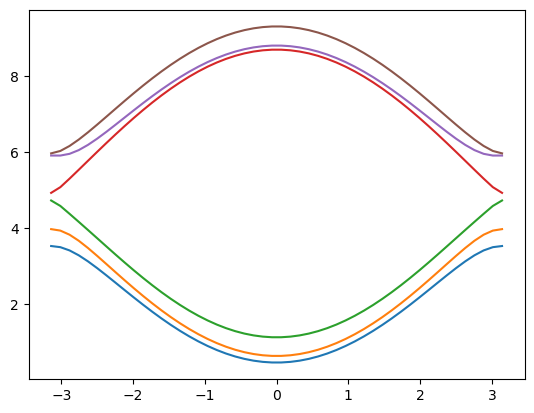

In [ ]:
chain = System(N, idxconn, dirconn, dphi=1.5)
chain.setEquilibrium([
    [0.1,0.8,0.5], 
    [0.1,0.8,0.5], 
    ])
chain.seriesExpansion()
chain.makeLagrangian()
chain.equations()
chain.Kmatrix()
chain.eigen()
chain.plotkx()
chain.berryPhase()
chain.bp

In [ ]:
chain.berryPhase(0)
2*np.pi-chain.bp

5.661932355279122

In [ ]:
idxconn = [
    [[0,1], [0,1],[0,3],[0,3]],
    [[1,0], [1,0],[1,2],[1,2]],
    [[2,1], [2,1],[2,3],[2,3]],
    [[3,0], [3,0],[3,2],[3,2]],
]
dirconn = [
    [[0,0],[-1,0],[0,0],[0,1]],
    [[0,0],[1,0],[0,0],[0,1]],
    [[0,0],[0,-1],[0,0],[1,0]],
    [[0,0],[0,-1],[0,0],[-1,0]],
]
ladder = System(4, idxconn, dirconn)
ladder.initialize([
    [0,0,0],
    [0,0,0],
    [0,0,0],
    [0,0,0],
])

C:\Users\gdela\AppData\Local\Temp\ipykernel_29484\2532180295.py:211: ComplexWarning: Casting complex values to real discards the imaginary part
  Z1[i,j] = eig[band1]
C:\Users\gdela\AppData\Local\Temp\ipykernel_29484\2532180295.py:212: ComplexWarning: Casting complex values to real discards the imaginary part
  Z2[i,j] = eig[band2]


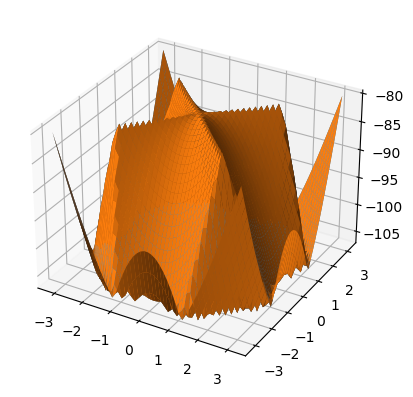

In [ ]:
ladder.plot2D(band1=4,band2=4)

C:\Users\gdela\AppData\Local\Temp\ipykernel_29484\2532180295.py:211: ComplexWarning: Casting complex values to real discards the imaginary part
  Z1[i,j] = eig[band1]
C:\Users\gdela\AppData\Local\Temp\ipykernel_29484\2532180295.py:212: ComplexWarning: Casting complex values to real discards the imaginary part
  Z2[i,j] = eig[band2]


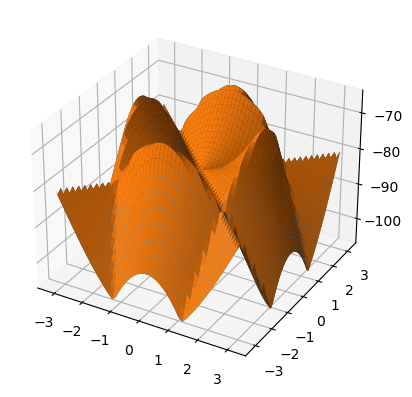

In [ ]:
ladder.plot2D(band1=5,band2=5)

C:\Users\gdela\AppData\Local\Temp\ipykernel_29484\2532180295.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  y[i] = np.sort(eig)


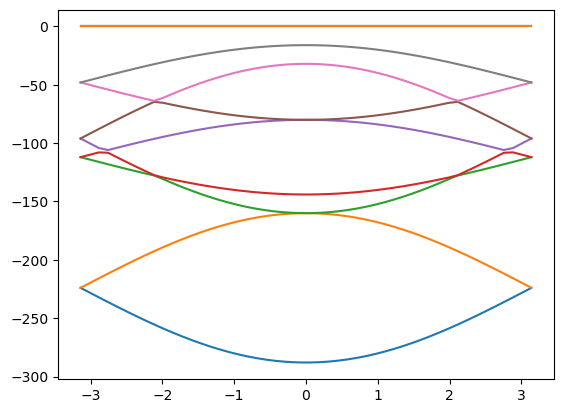

In [ ]:
ladder.plot2Dkx()

In [ ]:
np.linalg.norm(np.array([3,4j]))

5.0

In [ ]:
A = np.array(
    [
        [1,0,0],
        [0,3,0],
        [0,0,2],
    ]
)

B = np.array(
    [
        [1,0,0],
        [0,1,0],
        [0,0,1],
    ]
)

eig = sp.linalg.eig(A,B)

In [ ]:
np.argsort(eig[0])
b = []
for i in range(3):
    b.append()

array([0, 2, 1], dtype=int64)

In [ ]:
a = [4,3,5,6,2,1]
idx = np.argsort(a)
b = np.zeros(6)
for i in range(6):
    b[i] = a[idx[i]]
b

array([1., 2., 3., 4., 5., 6.])

In [340]:
class System2:
    def __init__(self, Nbase, indexConnections, dirconnections, a=1,k_v=1, k_k=1, k_a=1, dphi=0, Js=1):
        self.Nbase = Nbase
        self.indexConnections=indexConnections
        self.directionConnections = dirconnections
        self.a=a
        self.k = [sym.symbols("k_x"), sym.symbols("k_y")]
        self.k_v = k_v
        self.k_k = k_k
        self.k_a = k_a
        self.dphi=dphi

        t = sym.symbols('t')
        self.auxvar=[
                sym.Function(r"\theta_a")(t),
                sym.Function(r"\phi_a")(t),
                sym.Function(r"\psi_a")(t),
        ]
        self.auxvar2 = [
            sym.Function(r"\theta_b")(t),
            sym.Function(r"\phi_b")(t),
            sym.Function(r"\psi_b")(t),
        ]
        self.auxeq = [
            sym.symbols(r"\alpha"),
            sym.symbols(r"\beta"),
            sym.symbols(r"\gamma"),
        ]
        self.auxeq2 = [
            sym.symbols(r"\alpha_2"),
            sym.symbols(r"\beta_2"),
            sym.symbols(r"\gamma_2"),
        ]

        self.eigenvecs=None
        self.eigenvals=None

        if type(Js)==int: self.Js = 0 * self.indexConnections + self.k_v # todos tienen el mismo J 
        else:
            self.Js = Js  # debe ser un arreglo con el J de cada conexion


    def setEquilibrium(self, eq):
        t = sym.symbols('t')

        self.equilibrium = eq
        self.variables = []
        for i in range(self.Nbase):
            aux = [
                sym.Function(r"\theta_{}".format(i))(t),
                sym.Function(r"\phi_{}".format(i))(t),
                sym.Function(r"\psi_{}".format(i))(t),
            ]
            self.variables.append(aux)

        self.Rs = []
        for i in range(self.Nbase):
            R1 = R(
                self.equilibrium[i][0]+self.variables[i][0],
                self.equilibrium[i][1]+self.variables[i][1],
                self.equilibrium[i][2]+self.variables[i][2],
            )
            self.Rs.append(R1)

    def makeLagrangian(self):
        t = sym.symbols('t')

        Ls=[]

        for i in range(self.Nbase):
            kinetic = self.Kinetic(self.variables[i], self.equilibrium[i])
            potential = 0
            potential += self.Anisotropy(self.variables[i], self.equilibrium[i], i)
            for j in range(len(self.indexConnections[i])):
                idxconn = self.indexConnections[i][j]
                dirconn = self.directionConnections[i][j]
                k = 0
                for m in range(2):
                    k += dirconn[m]*self.k[m]
                factor = sym.exp(sym.I * self.a * k)
                if i==idxconn:
                    var = []
                    for z in self.auxvar:
                        var.append(z*factor)
                    potential += self.Potential(self.variables[i],self.equilibrium[i], var, self.equilibrium[idxconn], self.Js[i][j])
                else:
                    var=[]
                    for z in self.variables[idxconn]:
                        var.append(z*factor)
                    potential += self.Potential(self.variables[i], self.equilibrium[i], var,self.equilibrium[idxconn], self.Js[i][j])
            L = kinetic+potential
            Ls.append(L)
            #falta la anisotropía
        self.lagrangians=Ls

    def equations(self):
        t = sym.symbols('t')

        self.E_L_equations=[]
        for i in range(self.Nbase):
            eq = sym.euler_equations(self.lagrangians[i], self.variables[i],t)
            self.E_L_equations.append(eq)

        # Replace varsaux por la variable correspondiente por el factor
        # esto solo es necesario si tenemos conexion a-a o b-b, etc
        
    def Kmatrix(self):
        t = sym.symbols('t')
        ddvar = []
        for i in self.variables:
            l = []
            for j in i:
                l.append(j.diff(t,2))
            ddvar.append(l)

        self.K = coefficients(self.E_L_equations, self.variables)
        self.W = -1*coefficients(self.E_L_equations, ddvar) # el -1 es por dt^2 -> -w^2

    def Wmatrix(self):
        newvar = []
        for i in range(self.Nbase):
            newvar.append(
                [
                    sym.symbols("a_{}".format(i)),
                    sym.symbols("b_{}".format(i)),
                    sym.symbols("c_{}".format(i)),
                ]
            )

        eqs = []
        for leq in self.E_L_equations:
            l = []
            for eq in leq:
                x = eq
                for i in range(self.Nbase):
                    for j in range(3):
                        ddvar = self.variables[i][j].diff(t, 2)
                        x = x.subs(ddvar, newvar[i][j])
                l.append(x)
            eqs.append(l)

        self.W = -1*coefficients(eqs, newvar)

    def seriesExpansion(self):
        epsilon = sym.symbols(r"\epsilon")
        littleauxvar1 = [
            self.auxeq[0] + epsilon*self.auxvar[0],
            self.auxeq[1] + epsilon*self.auxvar[1],
            self.auxeq[2] + epsilon*self.auxvar[2],
        ]
        littleauxvar2 = [
            self.auxeq2[0] + epsilon*self.auxvar2[0],
            self.auxeq2[1] + epsilon*self.auxvar2[1],
            self.auxeq2[2] + epsilon*self.auxvar2[2],
        ]
        R1 = R(littleauxvar1[0], littleauxvar1[1], littleauxvar1[2])
        R2 = R(littleauxvar2[0], littleauxvar2[1], littleauxvar2[2])

        # self.V = sym.series(V(self.k_v, R1, R2),epsilon, 0, 3).removeO().subs(epsilon,1)
        # self.K = sym.series(K(self.k_k, R1),epsilon, 0, 3).removeO().subs(epsilon,1)
        self.V = V(self.k_v, R1, R2).diff(epsilon, 2).subs(epsilon,0)
        self.K = K(self.k_k, R1).diff(epsilon, 2).subs(epsilon,0)
        self.A = Anis(self.k_a, R1, self.auxeq, self.auxeq2[0]).diff(epsilon, 2).subs(epsilon,0)
        
    def Potential(self, angles1,eq1, angles2, eq2, k):
        return self.V.subs([
            (self.auxvar[0], angles1[0]),(self.auxvar[1], angles1[1]),(self.auxvar[2], angles1[2]),
            (self.auxeq[0], eq1[0]),(self.auxeq[1], eq1[1]),(self.auxeq[2], eq1[2]),
            (self.auxvar2[0], angles2[0]),(self.auxvar2[1], angles2[1]),(self.auxvar2[2], angles2[2]),
            (self.auxeq2[0], eq2[0]),(self.auxeq2[1], eq2[1]),(self.auxeq2[2], eq2[2]),
            (self.k_v, k)
            ])

    def Kinetic(self, angles1, eq1):
        return self.K.subs([
            (self.auxvar[0], angles1[0]),(self.auxvar[1], angles1[1]),(self.auxvar[2], angles1[2]),
            (self.auxeq[0], eq1[0]),(self.auxeq[1], eq1[1]),(self.auxeq[2], eq1[2]),
            ])
    
    def Anisotropy(self, angles1, eq1, idx):
        return self.A.subs([
            (self.auxvar[0], angles1[0]),(self.auxvar[1], angles1[1]),(self.auxvar[2], angles1[2]),
            (self.auxeq[0], eq1[0]),(self.auxeq[1], eq1[1]),(self.auxeq[2], eq1[2]),
            (self.auxeq2[0], ((-1)**idx)*self.dphi),
        ])

    def eigen(self, N=50):
        ks = np.linspace(-np.pi/self.a, np.pi/self.a, N)
        self.eigenvals = np.zeros([N, self.Nbase*3])
        self.eigenvecs = np.zeros([N, self.Nbase*3, self.Nbase*3], dtype=np.complex64)

        for i in range(N):
            A = np.array(self.K.subs(self.k[0], ks[i])).astype(dtype=complex)
            B = np.array(self.W.subs(self.k[0], ks[i])).astype(dtype=complex)
            eig = sp.linalg.eig(A,B)
            idx = np.argsort(eig[0].real)
            for j in range(self.Nbase*3):    
                self.eigenvals[i][j] = eig[0][idx[j]]
                self.eigenvecs[i][j] = eig[1][idx[j]]

    def eigen2D(self, N=50):
        kx = np.linspace(-np.pi/self.a, np.pi/self.a, N)
        ky = np.linspace(-np.pi/self.a, np.pi/self.a, N)
        X, Y = np.meshgrid(kx, ky)
        

        self.eigenvals = np.zeros([N,N,self.Nbase*3])
        self.eigenvecs = np.zeros([N,N,self.Nbase*3, self.Nbase*3])

        for i in range(N):
            for j in range(N):
                A = np.array(self.K.subs([(self.k[0], X[i,j]), (self.k[1], Y[i,j])])).astype(dtype=complex)
                B = np.array(self.W.subs([(self.k[0], X[i,j]), (self.k[1], Y[i,j])])).astype(dtype=complex)
                eig = sp.linalg.eig(A,B)
                idx = np.argsort(eig[0].real)
                print(eig[0])
                for k in range(self.Nbase*3):
                    self.eigenvals[i][j][k] = eig[0][idx[k]]
                    self.eigenvecs[i][j][k] = eig[1][idx[k]]

        fig = plt.figure()
        fig.clf()
        ax = plt.axes(projection='3d')
        # ax.plot_surface(X,Y, self.eigenvals[:,:,0])
        # ax.plot_surface(X,Y, self.eigenvals[:,:,1])
        ax.contour3D(X,Y,self.eigenvals[:,:,0],50, cmap='binary')
        ax.contour3D(X,Y,self.eigenvals[:,:,1],50,cmap='binary')



    def plotkx(self, N=50):
        ks = np.linspace(-np.pi/self.a, np.pi/self.a, N)
        y = np.zeros([N, self.Nbase*3])

        # if self.eigenvals==None:
        #     for i in range(N):
        #         M = np.array(self.K.subs(self.k[0], ks[i])).astype(dtype=complex)
        #         eig = np.linalg.eig(M)[0]
        #         y[i] = np.sort(eig)
        #     plt.plot(ks,y)

        # else:
        plt.plot(ks, self.eigenvals)
        
    def plot2Dkx(self, N=50, ky=0):
        ks = np.linspace(-np.pi/self.a, np.pi/self.a, N)
        y = np.zeros([N, self.Nbase*3])

        for i in range(N):
            M = np.array(self.K.subs([(self.k[0], ks[i]),(self.k[1],ky)])).astype(dtype=complex)
            eig = np.linalg.eig(M)[0]
            y[i] = np.sort(eig)
        plt.plot(ks,y)

    def plot2D(self, N=50, band1=0, band2=1):
        kx = np.linspace(-np.pi/self.a, np.pi/self.a, N)
        ky = np.linspace(-np.pi/self.a, np.pi/self.a, N)
        X, Y = np.meshgrid(kx, ky)
        
        fig = plt.figure()
        fig.clf()
        ax = plt.axes(projection='3d')
        ax.plot_surface(X,Y,self.eigenvals[:,:,band1])
        ax.plot_surface(X,Y,self.eigenvals[:,:,band2])
        # ax.contour3D(X,Y,Z1,50, cmap='binary')
        # ax.contour3D(X,Y,Z2,50,cmap='binary')

    def initialize(self, equilibrium):
        self.setEquilibrium(equilibrium)
        self.seriesExpansion()
        self.makeLagrangian()
        self.equations()
        self.Kmatrix()
    
    def berryPhase(self,band=0):
        N = len(self.eigenvals[:,0])
        bp=0
        for i in range(N):
            # bp += np.imag(np.dot(np.conj(self.eigenvecs[i][band])/np.linalg.norm(self.eigenvecs[i][band]),
                        #   self.eigenvecs[(i+1)%N][band]/np.linalg.norm(self.eigenvecs[(i+1)%N][band])-self.eigenvecs[i][0]/np.linalg.norm(self.eigenvecs[i][band]))
            # )
            bp += np.imag(
                np.log(np.dot(
                    np.conj(self.eigenvecs[i][band]),
                    self.eigenvecs[(i+1)%N][band]
                            ) / abs(np.dot(
                    np.conj(self.eigenvecs[i][band]),
                    self.eigenvecs[(i+1)%N][band]
                            ))
                    )
            )
            # bp += np.imag(
            #     np.log(np.dot(
            #         np.conj(self.eigenvecs[i][band])/np.linalg.norm(self.eigenvecs[i][band]),
            #         self.eigenvecs[(i+1)%N][band]/np.linalg.norm(self.eigenvecs[(i+1)%N][band])
            #                 )
            #         )
            # )
        self.bp=np.mod(bp, 2*np.pi) 

C:\Users\gdela\AppData\Local\Temp\ipykernel_29484\3461891298.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  self.eigenvals[i][j] = eig[0][idx[j]]


0.22232422858194667

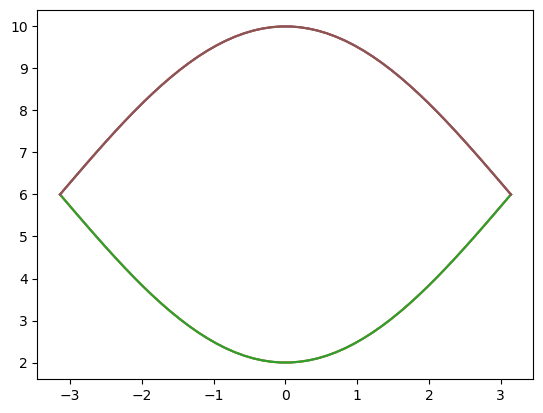

In [341]:
N=2
idxconn = np.array( [
    [1, 1],
    [0, 0],
])
# ahora la fila indica el rotor con el que se conecta, ie, la fila 0 dice que hay conexion [0,1], [0,1]

dirconn = [
    [[0,0], [-1,0]],
    [[0,0], [1,0]],
]

Js = np.array([
    [1,0.5],
    [1,0.5],
])

# chain = System2(N, idxconn, dirconn, dphi=0.0, Js=Js)
chain = System2(N, idxconn, dirconn, dphi=0.0)
chain.setEquilibrium([
    [np.pi/3,np.pi/3,np.pi/3], 
    [np.pi/3,np.pi/3,np.pi/3], 
    ])
# chain.setEquilibrium([
#     [0.1,0.8,0.5], 
#     [0.1,0.8,0.5], 
#     ])
chain.seriesExpansion()
chain.makeLagrangian()
chain.equations()
chain.Kmatrix()
chain.eigen()
chain.plotkx()
chain.berryPhase()
chain.bp

C:\Users\gdela\AppData\Local\Temp\ipykernel_29484\3461891298.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  self.eigenvals[i][j] = eig[0][idx[j]]


6.04622141553277

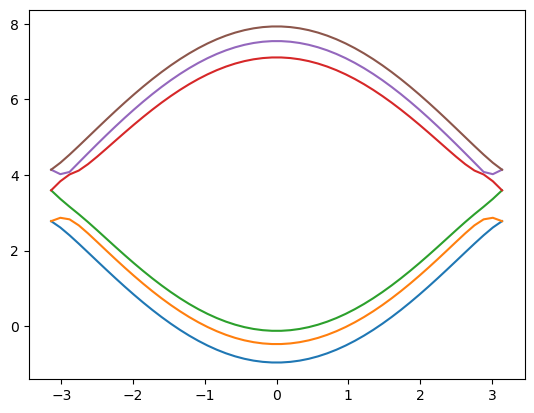

In [342]:
chain = System2(N, idxconn, dirconn, dphi=1.5)
chain.setEquilibrium([
    [np.pi/3,np.pi/3,np.pi/3], 
    [np.pi/3,np.pi/3,np.pi/3], 
    ])
# chain.setEquilibrium([
#     [0.1,0.8,0.5], 
#     [0.1,0.8,0.5], 
#     ])
chain.seriesExpansion()
chain.makeLagrangian()
chain.equations()
chain.Kmatrix()
chain.eigen()
chain.plotkx()
chain.berryPhase()
chain.bp

In [343]:
chain.W

Matrix([
[                 -8.0, -4.44089209850063e-16,                 -4.0,                     0,                     0,                    0],
[-4.44089209850063e-16,                  -8.0, 1.11022302462516e-16,                     0,                     0,                    0],
[                 -4.0,  1.11022302462516e-16,                 -8.0,                     0,                     0,                    0],
[                    0,                     0,                    0,                  -8.0, -4.44089209850063e-16,                 -4.0],
[                    0,                     0,                    0, -4.44089209850063e-16,                  -8.0, 1.11022302462516e-16],
[                    0,                     0,                    0,                  -4.0,  1.11022302462516e-16,                 -8.0]])

In [344]:
idxconn = np.array([
    [1, 1,3,3],
    [0, 0,2,2],
    [1, 1,3,3],
    [0, 0,2,2],
])
dirconn = [
    [[0,0],[-1,0],[0,0],[0,1]],
    [[0,0],[1,0],[0,0],[0,1]],
    [[0,0],[0,-1],[0,0],[1,0]],
    [[0,0],[0,-1],[0,0],[-1,0]],
]
ladder = System2(4, idxconn, dirconn)
ladder.initialize([
    [np.pi/3,np.pi/3,np.pi/3],
    [np.pi/3,np.pi/3,np.pi/3],
    [np.pi/3,np.pi/3,np.pi/3],
    [np.pi/3,np.pi/3,np.pi/3],
])
# ladder.initialize([
#     [0,0,0],
#     [0,0,0],
#     [0,0,0],
#     [0,0,0],
# ])

[10.+0.00000000e+00j 10.-9.92122552e-16j 10.-1.48224672e-15j
 10.-3.55393078e-15j 10.+4.84619922e-16j 10.-2.87574898e-15j
 10.-1.04116835e-15j 10.-8.97770029e-16j 10.+0.00000000e+00j
 10.+6.75322134e-16j 10.-2.41065397e-15j 10.-1.80180123e-15j]
[10.25628088+2.64548879e-17j  9.74371912+2.31957952e-17j
  9.74371912+2.29014739e-16j 10.25628088+3.43023099e-16j
  9.74371912-1.04290163e-15j 10.25628088-1.82259557e-15j
  9.74371912+0.00000000e+00j 10.25628088+1.80318031e-15j
  9.74371912-9.89735205e-16j 10.25628088-4.58985397e-16j
  9.74371912-1.31503792e-15j 10.25628088-9.26767726e-16j]
[10.51150865+2.29777262e-16j  9.48849135+2.17078885e-16j
  9.48849135-9.74763366e-17j 10.51150865-3.90000508e-16j
  9.48849135+1.54657002e-15j 10.51150865+2.66648243e-15j
  9.48849135+1.10538654e-15j 10.51150865-5.88518017e-16j
  9.48849135+2.56307203e-16j 10.51150865-9.97823690e-16j
  9.48849135-4.04835543e-16j 10.51150865-8.86109975e-16j]


C:\Users\gdela\AppData\Local\Temp\ipykernel_29484\3461891298.py:218: ComplexWarning: Casting complex values to real discards the imaginary part
  self.eigenvals[i][j][k] = eig[0][idx[k]]
C:\Users\gdela\AppData\Local\Temp\ipykernel_29484\3461891298.py:219: ComplexWarning: Casting complex values to real discards the imaginary part
  self.eigenvecs[i][j][k] = eig[1][idx[k]]


[ 9.23536549+4.30810409e-17j 10.76463451+5.62203253e-17j
  9.23536549+6.32891508e-16j 10.76463451+6.55863907e-16j
  9.23536549+1.11014196e-15j 10.76463451+0.00000000e+00j
 10.76463451-3.08646288e-16j  9.23536549+0.00000000e+00j
  9.23536549+0.00000000e+00j 10.76463451-1.67431824e-15j
  9.23536549-4.45488069e-16j 10.76463451-1.76550534e-15j]
[ 8.98538166+2.44624364e-17j 11.01461834+7.48389298e-17j
  8.98538166+7.56124971e-17j 11.01461834-5.52197569e-17j
  8.98538166+5.42076390e-16j 11.01461834+1.19389721e-15j
  8.98538166-1.53255634e-15j 11.01461834-7.56813761e-16j
  8.98538166-1.25657076e-15j 11.01461834+9.27239843e-16j
 11.01461834+2.10037933e-15j  8.98538166-2.53048838e-15j]
[ 8.73956713+1.73777391e-16j 11.26043287+2.23428074e-16j
  8.73956713+3.30406131e-16j 11.26043287+7.78600003e-16j
  8.73956713+1.43112711e-16j 11.26043287-3.16543340e-15j
  8.73956713+8.56864495e-16j 11.26043287+3.07106028e-15j
  8.73956713+0.00000000e+00j 11.26043287-2.59282313e-15j
  8.73956713+5.13913964e-16j 

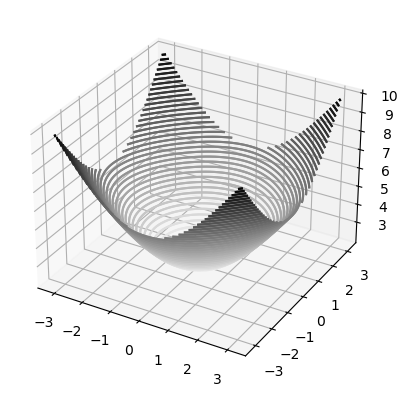

In [345]:
ladder.eigen2D()

In [347]:
# ladder.Wmatrix()
B = np.array(ladder.W, dtype=complex)
B
A = np.array(ladder.K.subs([(ladder.k[0], 0.5),(ladder.k[1],0.6)]), dtype=complex)
eig = sp.linalg.eig(A,B)

In [349]:
ladder.W

Matrix([
[                 -8.0, -4.44089209850063e-16,                 -4.0,                     0,                     0,                    0,                     0,                     0,                    0,                     0,                     0,                    0],
[-4.44089209850063e-16,                  -8.0, 1.11022302462516e-16,                     0,                     0,                    0,                     0,                     0,                    0,                     0,                     0,                    0],
[                 -4.0,  1.11022302462516e-16,                 -8.0,                     0,                     0,                    0,                     0,                     0,                    0,                     0,                     0,                    0],
[                    0,                     0,                    0,                  -8.0, -4.44089209850063e-16,                 -4.0,                     0,          

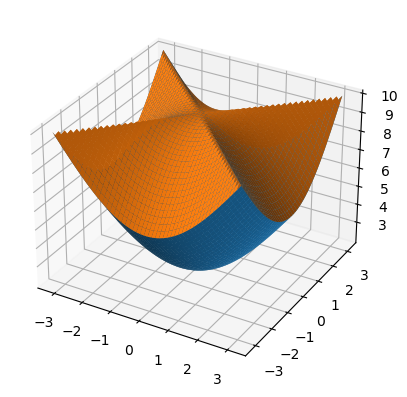

In [350]:
ladder.plot2D(band1=2,band2=3)

In [351]:
a = [
    [1,2,3],
    [1,2,3],
]

np.shape(a)

(2, 3)

In [4]:
import numpy as np

a = [1,1]
b =np.outer( np.linspace(0,1,10), a)
c = b + a

In [8]:
d = np.concatenate([b,c])
d

array([[0.        , 0.        ],
       [0.11111111, 0.11111111],
       [0.22222222, 0.22222222],
       [0.33333333, 0.33333333],
       [0.44444444, 0.44444444],
       [0.55555556, 0.55555556],
       [0.66666667, 0.66666667],
       [0.77777778, 0.77777778],
       [0.88888889, 0.88888889],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.11111111, 1.11111111],
       [1.22222222, 1.22222222],
       [1.33333333, 1.33333333],
       [1.44444444, 1.44444444],
       [1.55555556, 1.55555556],
       [1.66666667, 1.66666667],
       [1.77777778, 1.77777778],
       [1.88888889, 1.88888889],
       [2.        , 2.        ]])

In [17]:
c =np.random.random([10,10,4])
c

array([[[0.75736831, 0.55924958, 0.66491288, 0.80840011],
        [0.79897153, 0.99238252, 0.63615482, 0.92628693],
        [0.35565626, 0.80260865, 0.55611829, 0.35616031],
        [0.07958706, 0.40987873, 0.83775945, 0.24458838],
        [0.43701975, 0.68108287, 0.4643178 , 0.42375665],
        [0.43244941, 0.64385257, 0.73770657, 0.78017109],
        [0.66245293, 0.41683673, 0.23734995, 0.11499276],
        [0.57856057, 0.05000327, 0.21754152, 0.50792935],
        [0.67922191, 0.38229704, 0.12867118, 0.08980456],
        [0.38976839, 0.641155  , 0.89940611, 0.7760955 ]],

       [[0.44878714, 0.07144702, 0.7605069 , 0.69722442],
        [0.06306227, 0.71404778, 0.62075456, 0.15880009],
        [0.33720246, 0.48183446, 0.33020749, 0.71881896],
        [0.76597785, 0.00445601, 0.58808756, 0.08004645],
        [0.29829237, 0.08734514, 0.46933699, 0.9524716 ],
        [0.56074692, 0.52100632, 0.78056548, 0.7616252 ],
        [0.80828159, 0.67727984, 0.63189566, 0.16147498],
        [0.0

In [21]:
np.sum(c)

192.279997659951